$\space$

# ***Projet Prédiction de match de ligue 1 - Denis Bereziuc et Barthélémy Bengloan***



Pour ce projet, nous allons procéder en quatre étapes :


Analyse de donnéeses

Développement et analyse des performances du modèleèle

IPrédictionion



## I Analyse de données

Nous commençons par importer les modules classiques pour l'analyse de données.


In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections as clc
import pprint as p
import numpy as np


### Accées au données

Après une première exploration des données dans Excel, nous les importons ensuite dans des dataframes Pandas.

In [217]:
matches = pd.read_csv('matchs_2013_2022.csv')
game_events = pd.read_csv('game_events.csv', low_memory = False)
clubs_fr = pd.read_csv('clubs_fr.csv')
valuations_season = pd.read_csv('player_valuation_before_season.csv')

players_app = pd.read_csv('player_appearance.csv')
game_lineups = pd.read_csv('game_lineups.csv', low_memory = False)

prediction_example = pd.read_csv("prediction_example.csv")
predictions = pd.read_csv("match_2023.csv")

Nous vérifions d'abord que les données ont été correctement importées. Ensuite, nous entamons une réflexion sur la manière de les organiser et de les relier entre elles pour en extraire des informations pertinentes.

In [218]:
# On affiche les colonnes pour avoir un appercu de comment on va pouvoir agréger les données.

p.pp([matches.columns,
       game_events.columns, 
       clubs_fr.columns,
       valuations_season.columns,
       players_app.columns,
       game_lineups.columns,
       prediction_example.columns,
       predictions.columns])


[Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results'],
      dtype='object'),
 Index(['Unnamed: 0', 'game_event_id', 'date', 'game_id', 'minute', 'type',
       'club_id', 'player_id', 'description', 'player_in_id',
       'player_assist_id'],
      dtype='object'),
 Index(['club_id', 'club_code', 'name', 'domestic_competition_id', 'squad_size',
       'average_age', 'foreigners_number', 'foreigners_percentage',
       'national_team_players', 'stadium_name', 'stadium_seats',
       'net_transfer_record', 'coach_name'],
      dtype='object'),
 Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'pla

Les données sont bien chargées.

### Prétraitement des données

Nous nous assurons que les données sont homogènes, qu'il n'y a pas de valeurs manquantes (NaN), etc.

Commençons par placer les dataframes dans une liste afin de pouvoir les traiter ensemble.

In [219]:
#On regroupe les donnees les plus utiles pour notre etude
datasets = [matches, clubs_fr, players_app, valuations_season, game_lineups]

On cherche les NaN.

In [220]:
for df in datasets:
    print(df.isnull().sum(), '\n\n')

Unnamed: 0                  0
game_id                     0
season                      0
round                       0
date                        0
home_club_id                0
away_club_id                0
home_club_goals             0
away_club_goals             0
home_club_position          0
away_club_position          0
home_club_manager_name      0
away_club_manager_name      0
stadium                     0
attendance                337
referee                     0
home_club_formation       382
away_club_formation       382
home_club_name              0
away_club_name              0
aggregate                   0
competition_type            0
results                     0
dtype: int64 


club_id                     0
club_code                   0
name                        0
domestic_competition_id     0
squad_size                  0
average_age                 0
foreigners_number           0
foreigners_percentage       0
national_team_players       0
stadium_name            

On procède à la suppression :

In [221]:
matches = matches.drop(columns = ["Unnamed: 0", "attendance", "home_club_formation", "away_club_formation"])
clubs_fr = clubs_fr.drop(columns = ["coach_name"])

### Agrégation des données

Résultat à l'extérieur (away) vs à domicile (home) ainsi que les statistiques dérivées de ces résultats (décrit en annotation)

In [222]:
#On ajoute les victoires locales, victoires exterieurs et matches nuls
matches['home_win'] = (matches['results'] == 1).astype(int)
matches['home_loss'] = (matches['results'] == -1).astype(int)
matches['home_draw'] = (matches['results'] == 0).astype(int)
matches['ext_win'] = (matches['results'] == -1).astype(int)
matches['ext_loss'] = (matches['results'] == 1).astype(int)
matches['ext_draw'] = (matches['results'] == 0).astype(int)


Statistiques dérivées :

In [223]:
# On agrège les données
home_data = matches.groupby('home_club_id').agg(
    home_win_sum = ('home_win', 'sum'),
    home_loss_sum = ('home_loss', 'sum'),
    home_draw_sum = ('home_draw', 'sum'),
    home_club_goals_sum = ('home_club_goals', 'sum'),
    home_club_goals_mean = ('home_club_goals', 'mean'),
    ext_club_goals_sum = ('away_club_goals', 'sum'),
    ext_club_goals_mean = ('away_club_goals', 'mean'),
    ).reset_index()

home_data = home_data.rename(columns={"home_club_id":"club_id", 
                                      "home_club_goals_sum":"home_scored_g_sum", 
                                      "home_club_goals_mean":"home_scored_g_mean", 
                                      "ext_club_goals_sum":"home_tried_g_sum",
                                      "ext_club_goals_mean":"home_tried_g_mean"})
home_data

,club_id,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean
0,40,77,51,56,252,1.369565,211,1.146739
1,162,107,33,45,361,1.951351,194,1.048649
2,244,111,42,51,351,1.720588,216,1.058824
3,273,98,57,49,312,1.529412,214,1.049020
4,290,5,7,7,18,0.947368,28,1.473684
5,347,29,49,31,127,1.165138,177,1.623853
6,415,54,56,55,219,1.327273,218,1.321212
7,417,105,56,44,301,1.468293,215,1.048780
8,583,159,15,30,553,2.710784,137,0.671569
9,595,43,25,27,118,1.242105,90,0.947368


In [224]:
away_data = matches.groupby('away_club_id').agg(
    ext_win_sum = ('ext_win', 'sum'),
    ext_loss_sum = ('ext_loss', 'sum'),
    ext_draw_sum = ('ext_draw', 'sum'),
    ext_club_goals_sum = ('away_club_goals', 'sum'),
    ext_club_goals_mean = ('away_club_goals', 'mean'),
    home_club_goals_sum = ('home_club_goals', 'sum'),
    home_club_goals_mean = ('home_club_goals', 'mean'),
).reset_index()

away_data = away_data.rename(columns={"away_club_id":"club_id",
                                      "ext_club_goals_sum":"ext_scored_g_sum",
                                      "ext_club_goals_mean":"ext_scored_g_mean",
                                      "home_club_goals_sum":"ext_tried_g_sum",
                                      "home_club_goals_mean":"ext_tried_g_mean"})

away_data

,club_id,ext_win_sum,ext_loss_sum,ext_draw_sum,ext_scored_g_sum,ext_scored_g_mean,ext_tried_g_sum,ext_tried_g_mean
0,40,47,78,61,208,1.118280,281,1.510753
1,162,89,50,46,295,1.594595,230,1.243243
2,244,89,58,57,290,1.421569,238,1.166667
3,273,65,81,58,252,1.235294,267,1.308824
4,290,3,12,4,17,0.894737,35,1.842105
5,347,21,58,30,83,0.761468,184,1.688073
6,415,35,92,40,147,0.880240,268,1.604790
7,417,69,77,57,225,1.108374,256,1.261084
8,583,133,33,37,421,2.073892,183,0.901478
9,595,16,57,22,76,0.800000,174,1.831579


In [225]:
home_data.columns == away_data.columns

array([ True, False, False, False, False, False, False, False])

Nous avons calculé les statistiques et fusionné toutes ces informations dans un même tableau en utilisant "club_id" comme clé. Cela souligne l'importance de réaliser une indexation claire.

In [226]:
club_data = home_data.merge(away_data, on="club_id")
club_data

,club_id,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean,ext_win_sum,ext_loss_sum,ext_draw_sum,ext_scored_g_sum,ext_scored_g_mean,ext_tried_g_sum,ext_tried_g_mean
0,40,77,51,56,252,1.369565,211,1.146739,47,78,61,208,1.118280,281,1.510753
1,162,107,33,45,361,1.951351,194,1.048649,89,50,46,295,1.594595,230,1.243243
2,244,111,42,51,351,1.720588,216,1.058824,89,58,57,290,1.421569,238,1.166667
3,273,98,57,49,312,1.529412,214,1.049020,65,81,58,252,1.235294,267,1.308824
4,290,5,7,7,18,0.947368,28,1.473684,3,12,4,17,0.894737,35,1.842105
5,347,29,49,31,127,1.165138,177,1.623853,21,58,30,83,0.761468,184,1.688073
6,415,54,56,55,219,1.327273,218,1.321212,35,92,40,147,0.880240,268,1.604790
7,417,105,56,44,301,1.468293,215,1.048780,69,77,57,225,1.108374,256,1.261084
8,583,159,15,30,553,2.710784,137,0.671569,133,33,37,421,2.073892,183,0.901478
9,595,43,25,27,118,1.242105,90,0.947368,16,57,22,76,0.800000,174,1.831579


Ajoutons une métrique pour chaque club : la valeur de marché (market_value), basée sur la somme des valeurs marchandes des joueurs de l'équipe.

In [227]:
valuations_season.columns

Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')

In [228]:
# Valeur totale des jouer d'un club
club_players_value = valuations_season.groupby('current_club_id')['market_value_in_eur'].sum()
club_data['club_players_value'] = club_data['club_id'].map(club_players_value)

if not ("name" in club_data.columns.tolist()):
    club_data = club_data.merge(clubs_fr[['club_id', 'name']], on='club_id', how='left')
    cols = club_data.columns.tolist()
    cols.pop()
    cols.insert(1, "name")
    club_data = club_data[cols]

#Pour faciliter l'affichage
make_abrv = lambda club_name: ''.join(x for x in club_name if x.isupper())
abrv = { id:make_abrv(club_data[club_data["club_id"] == id]['name'].values[0]) for id in club_data["club_id"] }

if not ("name_abrv" in club_data.columns.tolist()):
    club_data["name_abrv"] = club_data["club_id"].map(abrv)
    cols = club_data.columns.tolist()
    cols.pop()
    cols.insert(2, "name_abrv")
    club_data = club_data[cols]


club_data.columns

Index(['club_id', 'name', 'name_abrv', 'home_win_sum', 'home_loss_sum',
       'home_draw_sum', 'home_scored_g_sum', 'home_scored_g_mean',
       'home_tried_g_sum', 'home_tried_g_mean', 'ext_win_sum', 'ext_loss_sum',
       'ext_draw_sum', 'ext_scored_g_sum', 'ext_scored_g_mean',
       'ext_tried_g_sum', 'ext_tried_g_mean', 'club_players_value'],
      dtype='object')

In [229]:
# Matchs joués
club_data['total_matches'] = club_data[['home_win_sum', 'home_draw_sum', 'home_loss_sum', 'ext_win_sum', 'ext_draw_sum', 'ext_loss_sum']].sum(axis=1)


# Moyennes
club_data['average_goals_scored'] = club_data[['home_scored_g_sum', 'ext_scored_g_sum']].sum(axis=1) / club_data['total_matches']
club_data['average_goals_conceded'] = club_data[['home_tried_g_sum', 'ext_tried_g_sum']].sum(axis=1) / club_data['total_matches']
club_data['average_goals_scored_home'] = club_data['home_scored_g_sum'] / club_data[['home_win_sum', 'home_draw_sum', 'home_loss_sum']].sum(axis=1)
club_data['average_goals_scored_away'] = club_data['ext_scored_g_sum'] / club_data[['ext_win_sum', 'ext_draw_sum', 'ext_loss_sum']].sum(axis=1)

# Pourcentages
club_data['percentage_wins'] = (club_data[['home_win_sum', 'ext_win_sum']].sum(axis=1) / club_data['total_matches']) * 100
club_data['percentage_draws'] = (club_data[['home_draw_sum', 'ext_win_sum']].sum(axis=1) / club_data['total_matches']) * 100
club_data['percentage_losses'] = (club_data[['home_loss_sum', 'ext_loss_sum']].sum(axis=1) / club_data['total_matches']) * 100
club_data['goals_per_match'] = club_data[['home_scored_g_sum', 'ext_scored_g_sum']].sum(axis=1) / club_data['total_matches']

# Ratio but marqué/encaissé
club_data['efficiency_ratio'] = club_data[['home_scored_g_sum', 'ext_scored_g_sum']].sum(axis=1) / club_data[['home_tried_g_sum', 'ext_tried_g_sum']].sum(axis=1)

# Calcul de la différence de buts
club_data['goal_diff'] = club_data[['home_scored_g_sum', 'ext_scored_g_sum']].sum(axis=1) - club_data[['home_tried_g_sum', 'ext_tried_g_sum']].sum(axis=1)



Attribuons des points pour différentes issues d'un match : 3 points pour une victoire, 1 point pour un match nul et 0 point pour une défaite.

In [230]:
# Calcul des points par match
points_total = (club_data['home_win_sum'] + club_data['ext_win_sum']) * 3
points_total += (club_data['home_draw_sum'] + club_data['ext_draw_sum'])
club_data['points_per_match'] = points_total / club_data['total_matches']


club_data.columns

Index(['club_id', 'name', 'name_abrv', 'home_win_sum', 'home_loss_sum',
       'home_draw_sum', 'home_scored_g_sum', 'home_scored_g_mean',
       'home_tried_g_sum', 'home_tried_g_mean', 'ext_win_sum', 'ext_loss_sum',
       'ext_draw_sum', 'ext_scored_g_sum', 'ext_scored_g_mean',
       'ext_tried_g_sum', 'ext_tried_g_mean', 'club_players_value',
       'total_matches', 'average_goals_scored', 'average_goals_conceded',
       'average_goals_scored_home', 'average_goals_scored_away',
       'percentage_wins', 'percentage_draws', 'percentage_losses',
       'goals_per_match', 'efficiency_ratio', 'goal_diff', 'points_per_match'],
      dtype='object')

### Plot

On se propose egalement de faire certains graphes pour avoir un visuel sur nos statistiques

1.  Graphiques des buts marqués à domicile et à l'extérieur pour chaque club


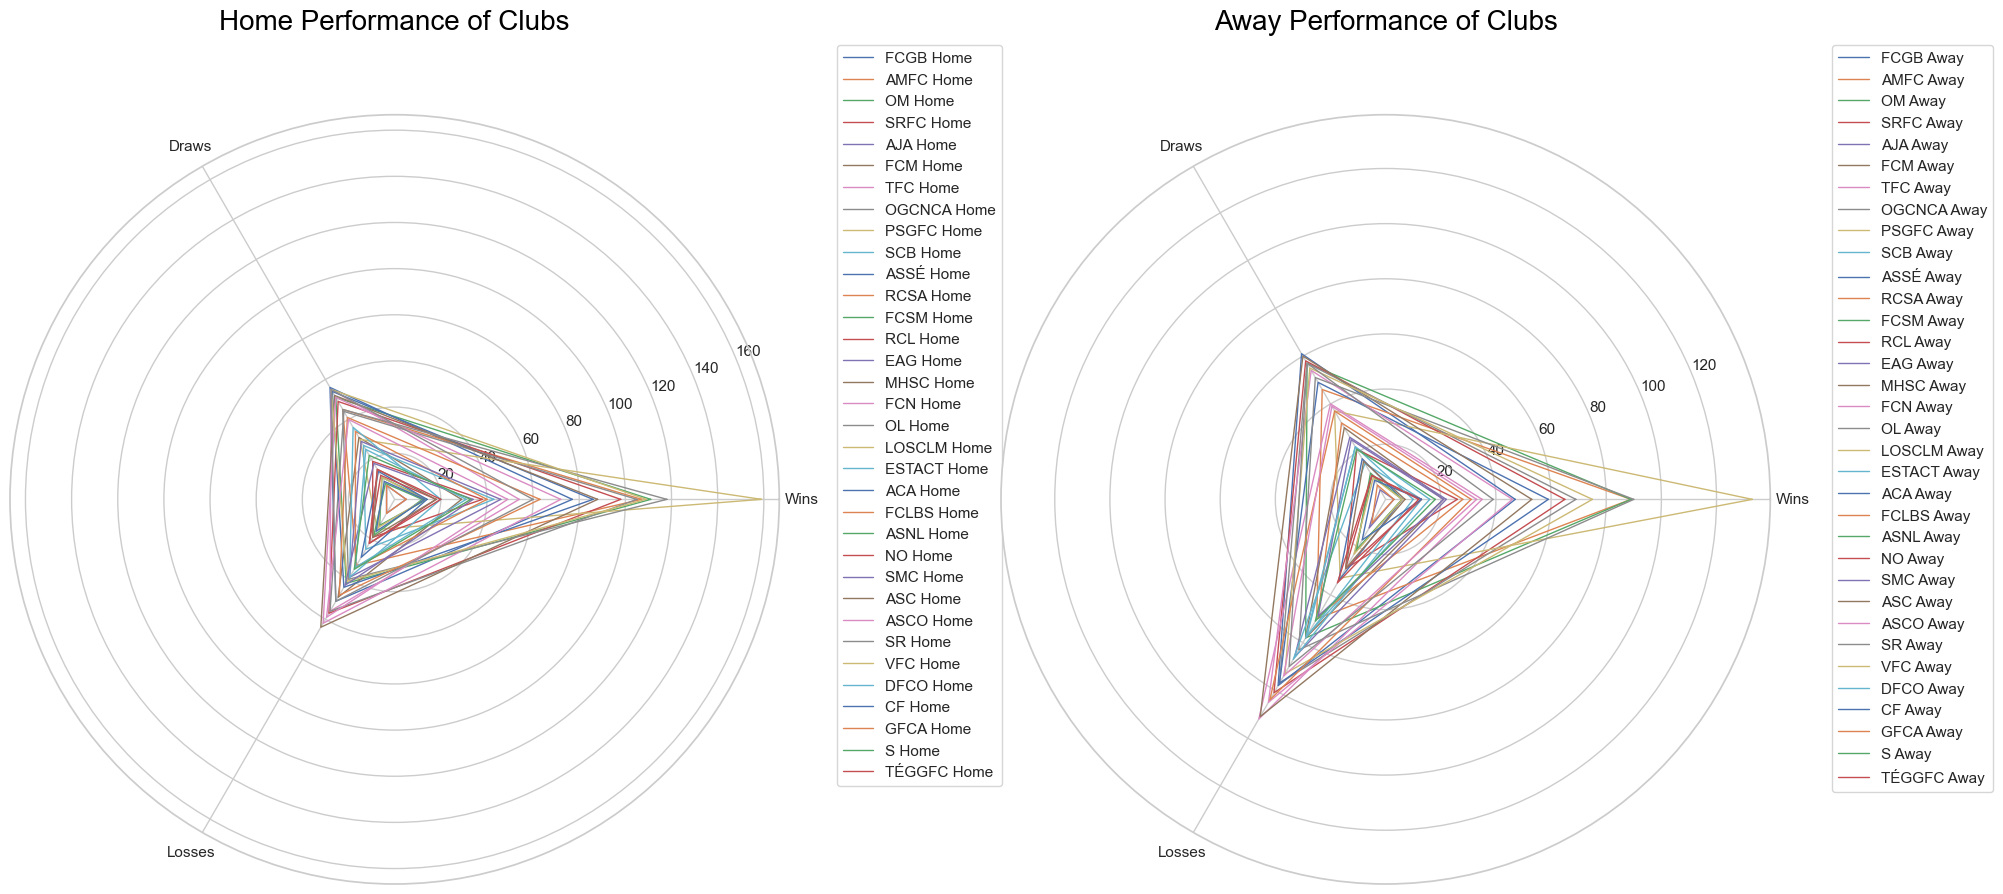

In [231]:
categories = ['Wins', 'Draws', 'Losses']
N = len(categories)

def get_values(df, win_col, draw_col, loss_col):
    values = df[[win_col, draw_col, loss_col]].values
    return [v.tolist() + [v[0]] for v in values]

home_values = get_values(club_data, 'home_win_sum', 'home_draw_sum', 'home_loss_sum')
away_values = get_values(club_data, 'ext_win_sum', 'ext_draw_sum', 'ext_loss_sum')

fig, axs = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

for i, club in enumerate(club_data['name_abrv']):
    axs[0].plot(angles, home_values[i], linewidth=1, linestyle='solid', label=f"{club} Home")
    
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(categories)
axs[0].set_title('Home Performance of Clubs', size=20, color='black', y=1.1)
axs[0].legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

for i, club in enumerate(club_data['name_abrv']):
    axs[1].plot(angles, away_values[i], linewidth=1, linestyle='solid', label=f"{club} Away")
    
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(categories)
axs[1].set_title('Away Performance of Clubs', size=20, color='black', y=1.1)
axs[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

Très inégale en fonction des différentes équipes

2. Créer un graphique en barres montrant le nombre de victoires, de matchs nuls et de défaites pour chaque club.

<Figure size 1800x1000 with 0 Axes>

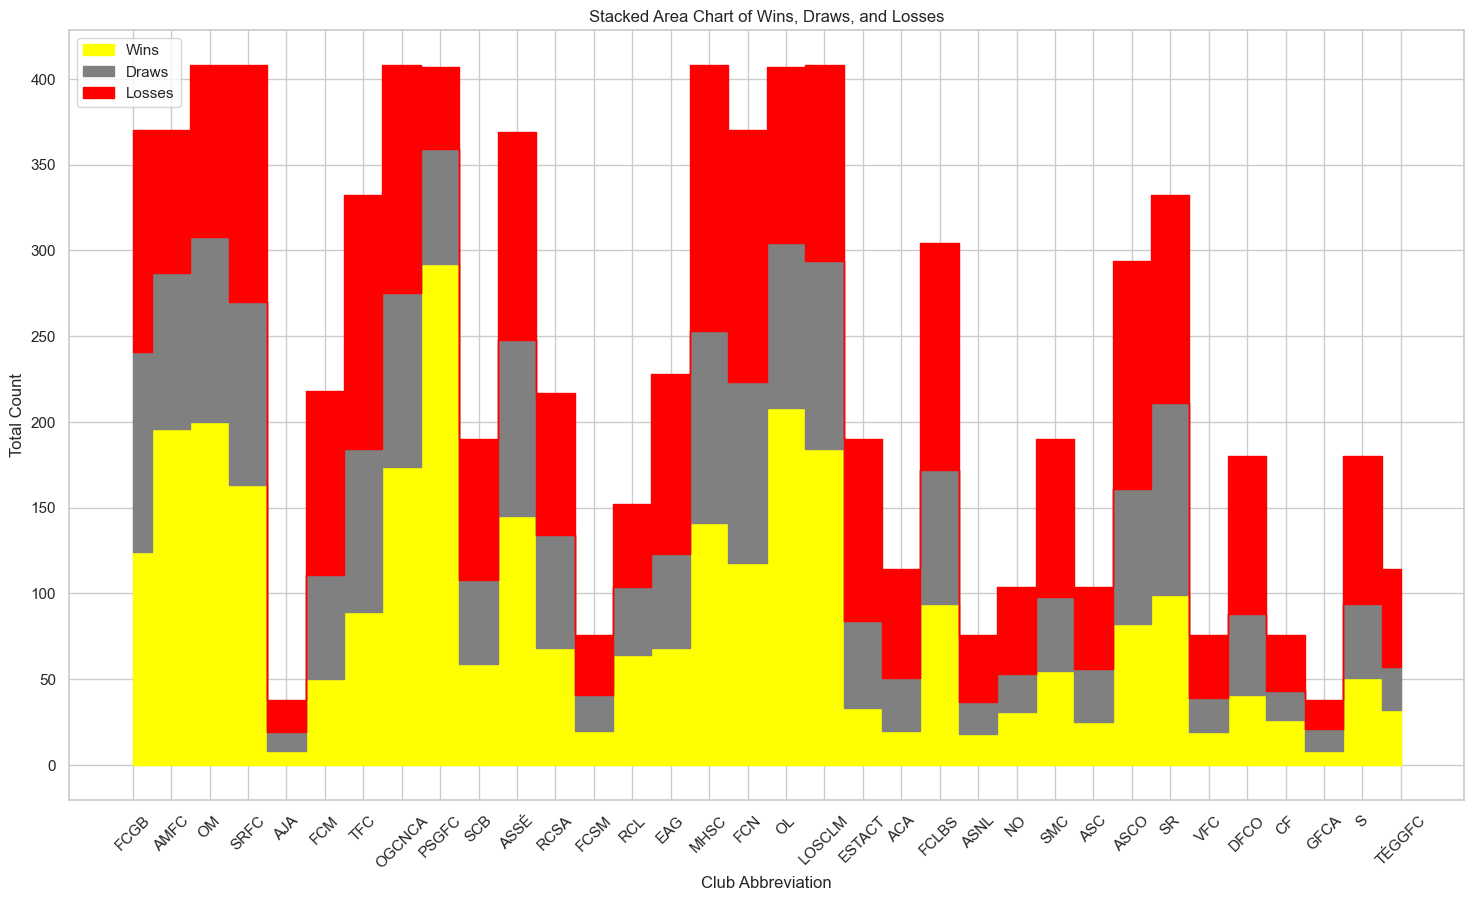

In [232]:
sns.set(style="whitegrid")

plt.figure(figsize = (18, 10))
total_wins = club_data['home_win_sum'] + club_data['ext_win_sum']
total_draws = club_data['home_draw_sum'] + club_data['ext_draw_sum']
total_losses = club_data['home_loss_sum'] + club_data['ext_loss_sum']

indices = range(len(club_data['name_abrv']))

wins = total_wins.values
draws = total_draws.values
losses = total_losses.values

# Création du graphique en aires empilées
plt.figure(figsize=(18, 10))

plt.fill_between(indices, wins, label='Wins', color='yellow', step='mid')
plt.fill_between(indices, wins + draws, wins, label='Draws', color='gray', step='mid')
plt.fill_between(indices, wins + draws + losses, wins + draws, label='Losses', color='red', step='mid')

# Configuration des étiquettes et du titre
plt.xlabel('Club Abbreviation')
plt.ylabel('Total Count')
plt.title('Stacked Area Chart of Wins, Draws, and Losses')
plt.legend(loc='upper left')

# Configuration des ticks et rotation des labels
plt.xticks(indices, club_data['name_abrv'], rotation=45)

# Affichage du graphique
plt.show()


Les données varient beaucoup pour chaque club

3. 
Créer un graphique montrant la relation entre le nombre de victoires et la valeur marchande des joueurs de chaque club.e club.

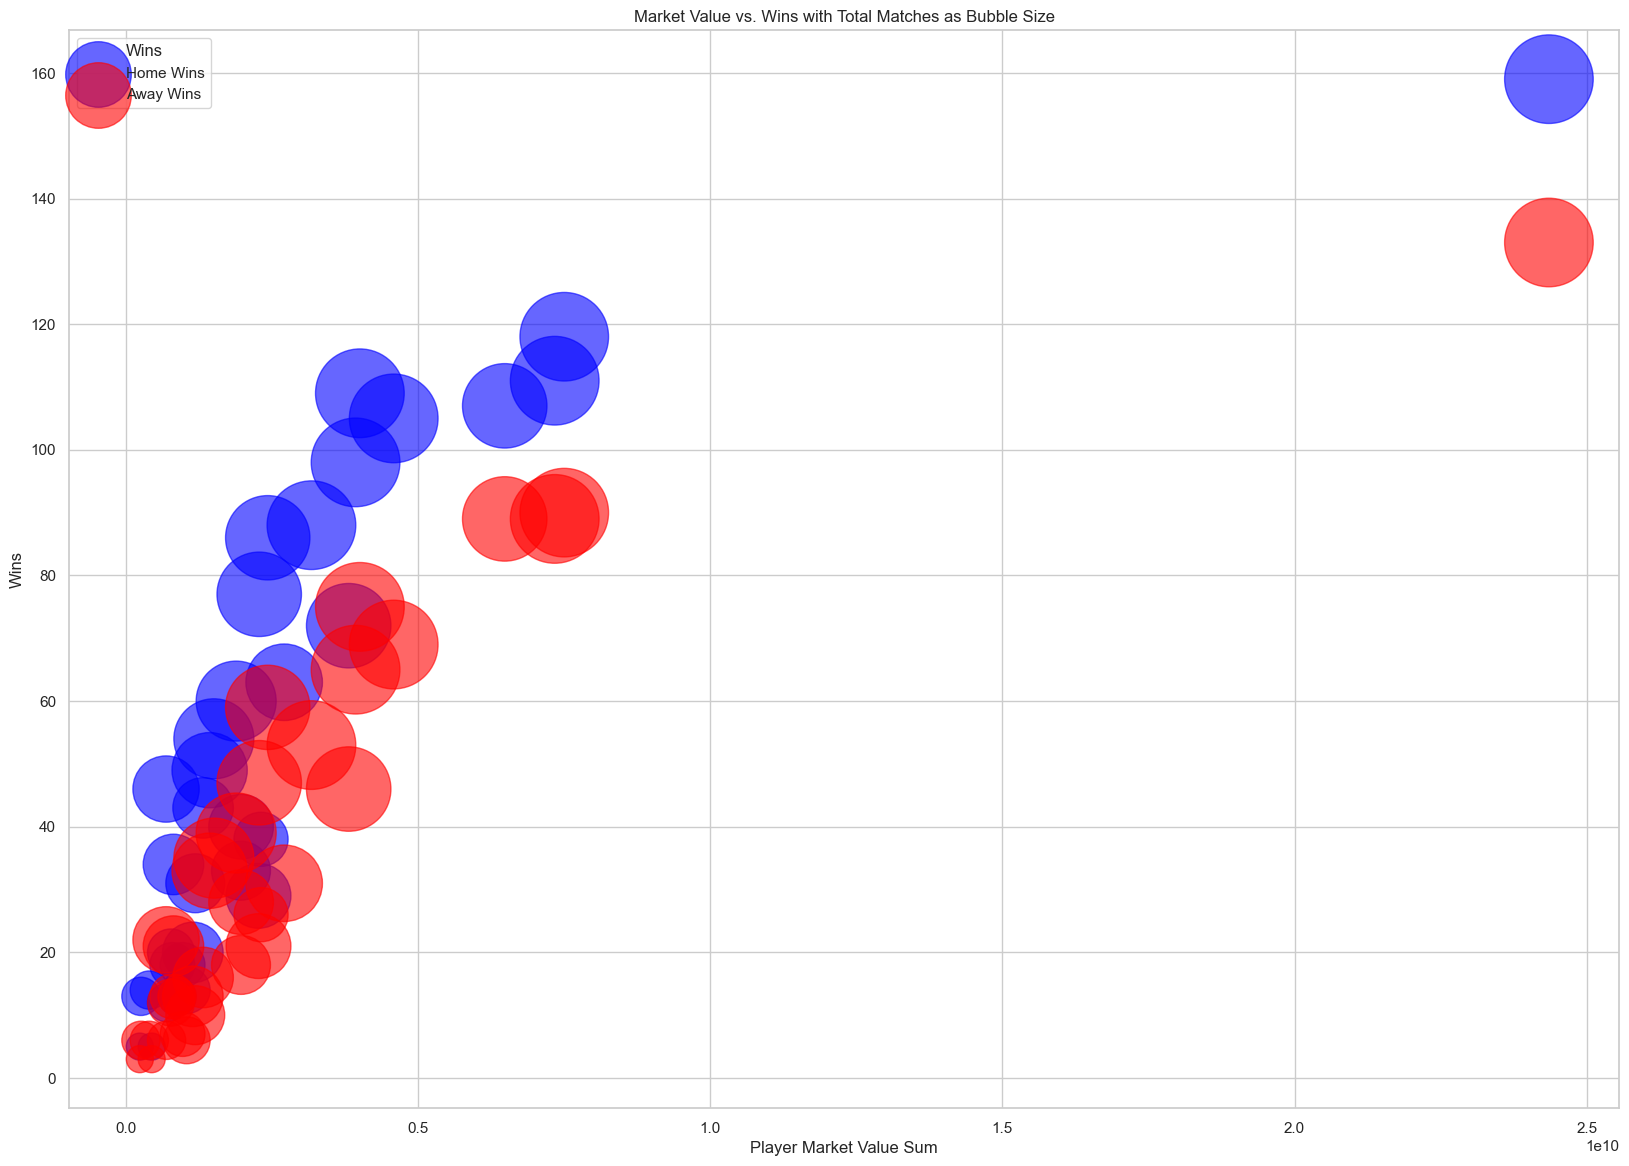

In [233]:
plt.figure(figsize=(20, 14))
plt.scatter(
    club_data['club_players_value'],
    club_data['home_win_sum'],
    s=club_data['total_matches']*10,  # Taille des bulles en fonction du nombre total de matchs
    color='blue',
    alpha=0.6,
    label='Home Wins'
)
plt.scatter(
    club_data['club_players_value'],
    club_data['ext_win_sum'],
    s=club_data['total_matches']*10,  # Taille des bulles en fonction du nombre total de matchs
    color='red',
    alpha=0.6,
    label='Away Wins'
)
plt.title('Market Value vs. Wins with Total Matches as Bubble Size')
plt.xlabel('Player Market Value Sum')
plt.ylabel('Wins')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Wins')

plt.show()

4.  Matrice de corrélation

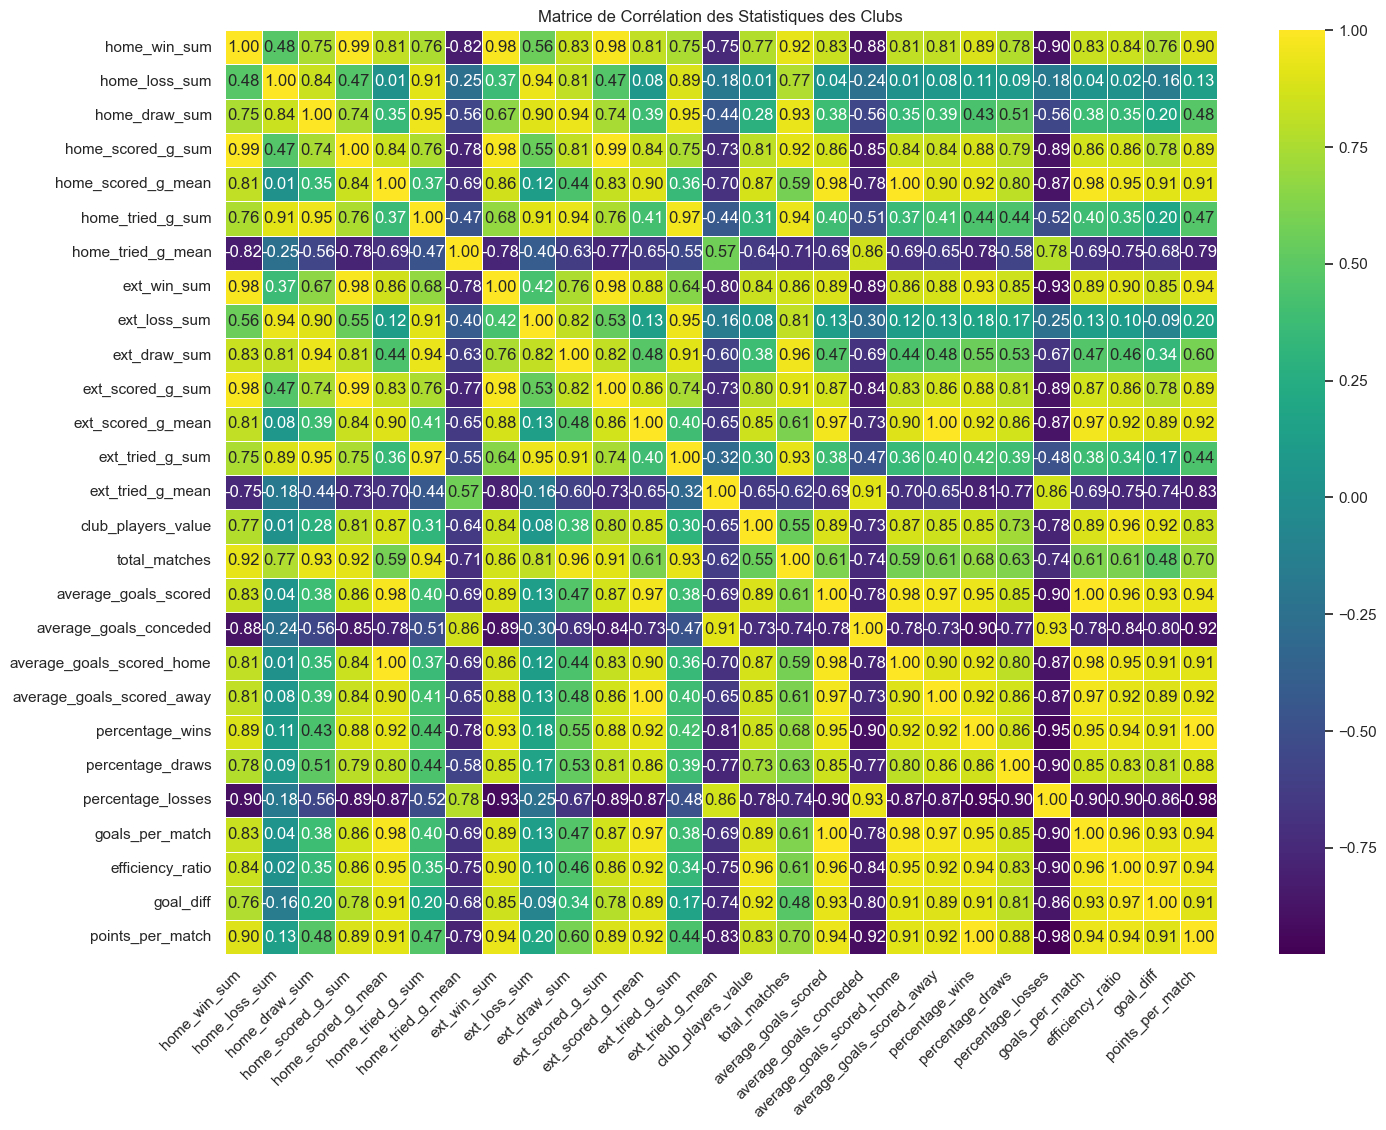

In [234]:
# On prend toutes les colonnes après la 3ème pour calculer la matrice de corrélation.
numeric_cols = club_data.select_dtypes(include=[np.number]).columns[1:]

# Calcul de la matrice de corrélation
correlation_matrix = club_data[numeric_cols].corr()

# Affichage de la matrice de corrélation avec heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title('Matrice de Corrélation des Statistiques des Clubs')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Une matrice de corrélation peut être assez difficile à comprendre, surtout pour nous qui commençons tout juste à explorer ces concepts. Pour améliorer sa lisibilité et sa compréhension, nous apporterons des ajustements dans la partie suivante.

## II Développement et analyse des performances du modèle


### II.1 Partie théorique

Dans cette partie, nous allons d'abord expliquer la théorie avant de passer aux algorithmes plus complexes.

Pour prédire le résultat d'un match entre deux équipes à partir d'un identifiant de match (match_id), il est essentiel que les valeurs d'entrée soient cohérentes avec les données que nous avons analysées précédemment.

Il est donc important de noter que nos prédictions seront basées sur les données des matchs joués entre 2013 et 2022. Les colonnes les plus importantes à considérer sont home_club_id, away_club_id et results.

### Préparation des datasets de modélisation et prédiction

Agrégation des statistiques et des résultats.

In [235]:
matches_data = pd.read_csv('matchs_2013_2022.csv')

# Liste des colonnes à supprimer, pas trés importantes dans le cadre de la prédiction
columns_to_drop = [
    'Unnamed: 0', 'game_id', 'season', 'round', 'date', 
    'home_club_goals', 'away_club_goals', 'home_club_position', 
    'away_club_position', 'home_club_manager_name', 'away_club_manager_name', 
    'stadium', 'attendance', 'referee', 'home_club_formation', 
    'away_club_formation', 'home_club_name', 'away_club_name', 
    'aggregate', 'competition_type'
]

matches_data.drop(columns=columns_to_drop, inplace=True)
matches_data

,home_club_id,away_club_id,results
0,618,595,0
1,14171,855,-1
2,1423,1082,-1
3,273,14171,0
4,1147,273,1
...,...,...,...
4073,40,162,1
4074,667,969,-1
4075,415,667,-1
4076,162,667,-1


Pour la prediction

In [236]:
match_pred = pd.read_csv('match_2023.csv')

# Liste des colonnes à supprimer, pas trés importantes dans le cadre de la prédiction
columns_to_drop = [
    'date', 'home_club_manager_name', 'away_club_manager_name', 
    'stadium', 'attendance', 'referee', 'home_club_name', 
    'away_club_name', 'competition_type'
]

match_pred.drop(columns=columns_to_drop, inplace=True)
match_pred

,game_id,home_club_id,away_club_id
0,4094596,583,826
1,4094622,826,347
2,4094630,969,273
3,4094647,347,417
4,4094696,244,273
...,...,...,...
265,4094819,738,969
266,4094840,415,244
267,4094776,583,273
268,4094786,415,417


Nous allons normaliser les données des clubs avant de les fusionner avec les données récupérées.





In [237]:
from sklearn.preprocessing import StandardScaler

club_data_norm = club_data.copy()
Cols = club_data.columns[3:]
Cols
scalar = StandardScaler()
club_data_norm = club_data.copy()
club_data_norm[Cols] = scalar.fit_transform(club_data[Cols])
club_data_norm

,club_id,name,name_abrv,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean,...,average_goals_conceded,average_goals_scored_home,average_goals_scored_away,percentage_wins,percentage_draws,percentage_losses,goals_per_match,efficiency_ratio,goal_diff,points_per_match
0,40,FC Girondins Bordeaux,FCGB,0.610493,0.949115,1.440329,0.591526,0.004211,1.153315,-0.368855,...,-0.309007,0.004211,0.241533,0.069868,0.325226,-0.594423,0.113667,0.019764,-0.212574,0.234407
1,162,Association sportive de Monaco Football Club,AMFC,1.373610,-0.144780,0.792094,1.451548,1.710697,0.887731,-0.820862,...,-1.151918,1.710697,1.897001,1.796992,2.018316,-1.826437,1.843868,1.345588,1.541165,1.823926
2,244,Olympique de Marseille,OM,1.475359,0.402167,1.145677,1.372647,1.033826,1.231428,-0.773976,...,-1.304191,1.033826,1.295636,1.446111,1.633864,-1.620576,1.184441,1.052631,1.242232,1.514881
3,273,Stade Rennais Football Club,SRFC,1.144675,1.313747,1.027816,1.064933,0.473071,1.200183,-0.819153,...,-1.000678,0.473071,0.648226,0.641225,0.346109,-0.697616,0.568026,0.534314,0.551365,0.665169
4,290,AJ Auxerre,AJA,-1.220987,-1.724851,-1.447262,-1.254760,-1.234169,-1.705619,1.137730,...,1.196097,-1.234169,-0.535405,-1.036097,0.017653,0.905420,-0.938671,-0.801886,-0.186003,-1.005506
5,347,Football Club de Metz,FCM,-0.610493,0.827571,-0.032932,-0.394738,-0.595412,0.622147,1.829719,...,1.187239,-0.595412,-0.998591,-0.868959,-0.479981,0.814505,-0.800674,-0.745229,-1.003086,-0.860527
6,415,Toulouse Football Club,TFC,0.025437,1.252975,1.381399,0.331153,-0.119840,1.262673,0.435128,...,0.306150,-0.119840,-0.585792,-0.525348,0.177829,0.368148,-0.346323,-0.374106,-0.797154,-0.481431
7,417,Olympique Gymnaste Club Nice Côte d'Azur,OGCNCA,1.322735,1.252975,0.733164,0.978142,0.293797,1.215805,-0.820255,...,-1.113090,0.293797,0.207107,0.880516,0.296580,-0.819058,0.263822,0.413506,0.365362,0.870010
8,583,Paris Saint-Germain Football Club,PSGFC,2.696345,-1.238676,-0.091862,2.966450,3.938252,-0.002757,-2.558472,...,-2.801679,3.938252,3.562832,3.463056,2.792867,-2.880710,3.869392,4.586634,4.344490,3.315336
9,595,SC Bastia,SCB,-0.254372,-0.630956,-0.268653,-0.465749,-0.369652,-0.737019,-1.287568,...,-0.034996,-0.369652,-0.864670,-0.148548,-0.726846,0.227389,-0.612051,-0.413603,-0.465007,-0.174641


Nous fusionnons les données en utilisant une jointure gauche sur home_club_id et une jointure droite sur club_id, puis nous procédons de la même manière pour away_club_id.

In [238]:
# Fusion des statistiques pour l'équipe à domicile
merged_data = matches_data.copy()

# Fusion des statistiques pour les équipes à domicile et à l'extérieur
for location in ['home', 'away']:
    merged_data = merged_data.merge(
        club_data_norm,
        how='left',
        left_on=f'{location}_club_id',
        right_on='club_id',
        suffixes=('', f'_{location}')
    )

matches_data

,home_club_id,away_club_id,results
0,618,595,0
1,14171,855,-1
2,1423,1082,-1
3,273,14171,0
4,1147,273,1
...,...,...,...
4073,40,162,1
4074,667,969,-1
4075,415,667,-1
4076,162,667,-1


On retire les colonnes qui ne sont pas pertinentes à la prédiction.

In [239]:
cols_to_drop = ['club_id', 'name', 'name_abrv', 'club_id_away', 'name_away', 'name_abrv_away', 'club_id_home', 'name_home', 'name_abrv_home']

merged_data.drop(columns = cols_to_drop, 
                 inplace = True, 
                 errors = 'ignore')

X = merged_data.drop(['results','away_club_id', 'home_club_id'], axis=1) 
y = merged_data['results'] 



In [240]:
merged_data.columns

Index(['home_club_id', 'away_club_id', 'results', 'home_win_sum',
       'home_loss_sum', 'home_draw_sum', 'home_scored_g_sum',
       'home_scored_g_mean', 'home_tried_g_sum', 'home_tried_g_mean',
       'ext_win_sum', 'ext_loss_sum', 'ext_draw_sum', 'ext_scored_g_sum',
       'ext_scored_g_mean', 'ext_tried_g_sum', 'ext_tried_g_mean',
       'club_players_value', 'total_matches', 'average_goals_scored',
       'average_goals_conceded', 'average_goals_scored_home',
       'average_goals_scored_away', 'percentage_wins', 'percentage_draws',
       'percentage_losses', 'goals_per_match', 'efficiency_ratio', 'goal_diff',
       'points_per_match', 'home_win_sum_away', 'home_loss_sum_away',
       'home_draw_sum_away', 'home_scored_g_sum_away',
       'home_scored_g_mean_away', 'home_tried_g_sum_away',
       'home_tried_g_mean_away', 'ext_win_sum_away', 'ext_loss_sum_away',
       'ext_draw_sum_away', 'ext_scored_g_sum_away', 'ext_scored_g_mean_away',
       'ext_tried_g_sum_away', 'ext_t

Si la colonne est suivit du préfixe "_away" il s'agit alors de donnée de l'équipe away. Enfin :

In [241]:
X

,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean,ext_win_sum,ext_loss_sum,ext_draw_sum,...,average_goals_conceded_away,average_goals_scored_home_away,average_goals_scored_away_away,percentage_wins_away,percentage_draws_away,percentage_losses_away,goals_per_match_away,efficiency_ratio_away,goal_diff_away,points_per_match_away
0,0.839428,0.523711,1.322468,0.796669,0.418683,0.872108,-0.819644,0.752903,0.995385,0.930303,...,-0.034996,-0.369652,-0.864670,-0.148548,-0.726846,0.227389,-0.612051,-0.413603,-0.465007,-0.174641
1,-0.839428,-0.813272,-0.975819,-0.797133,-0.102063,-0.986980,0.329297,-0.745402,-0.746539,-1.149936,...,0.290882,-0.179252,-0.748818,-0.257545,-0.780025,0.514248,-0.451607,-0.418185,-0.591223,-0.340271
2,-1.017489,-1.299448,-1.211540,-0.962826,0.232422,-1.330677,0.652670,-0.936675,-1.244232,-1.203275,...,-1.641428,0.422571,0.429681,1.098052,1.138573,-1.280538,0.439940,0.793964,0.823726,1.165892
3,1.144675,1.313747,1.027816,1.064933,0.473071,1.200183,-0.819153,0.944176,1.161283,1.410358,...,0.270766,-0.102063,-0.596380,-0.413255,-0.514132,0.905420,-0.337003,-0.361221,-0.265718,-0.571066
4,-0.992052,-0.387868,-1.034749,-0.986496,-1.337088,-0.846377,1.056887,-0.936675,-0.788014,-0.776560,...,-1.000678,0.473071,0.648226,0.641225,0.346109,-0.697616,0.568026,0.534314,0.551365,0.665169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0.610493,0.949115,1.440329,0.591526,0.004211,1.153315,-0.368855,0.370357,1.036860,1.570376,...,-1.151918,1.710697,1.897001,1.796992,2.018316,-1.826437,1.843868,1.345588,1.541165,1.823926
4074,-0.330684,-0.084008,0.143860,-0.118584,0.386800,0.028488,0.277647,-0.235341,-0.165898,0.023532,...,-0.225032,0.386800,0.341558,0.162644,-0.099652,-0.284713,0.375897,0.121243,-0.066430,0.202379
4075,0.025437,1.252975,1.381399,0.331153,-0.119840,1.262673,0.435128,-0.012189,1.617501,0.450248,...,0.080916,0.386800,0.563822,-0.123361,0.473469,-0.259081,0.478160,0.068914,-0.086358,-0.005119
4076,1.373610,-0.144780,0.792094,1.451548,1.710697,0.887731,-0.820862,1.709267,-0.124423,0.770284,...,0.080916,0.386800,0.563822,-0.123361,0.473469,-0.259081,0.478160,0.068914,-0.086358,-0.005119


In [242]:
y


0       0
1      -1
2      -1
3       0
4       1
       ..
4073    1
4074   -1
4075   -1
4076   -1
4077    1
Name: results, Length: 4078, dtype: int64

### Analyse en Composante Principale (PCA)


Dans cette section, nous allons entraîner le modèle de PCA. La normalisation des données a déjà été effectuée à l'aide du scaler.

In [243]:
from sklearn.decomposition import PCA

Variable de variance expliquée objectif.

In [244]:
goal_var = 0.985 # On veut expliquer goal_car * 100 % de la variance

Le vecteur $X$ est déjà normalisé car club_stat a été normalisé avant le merge.

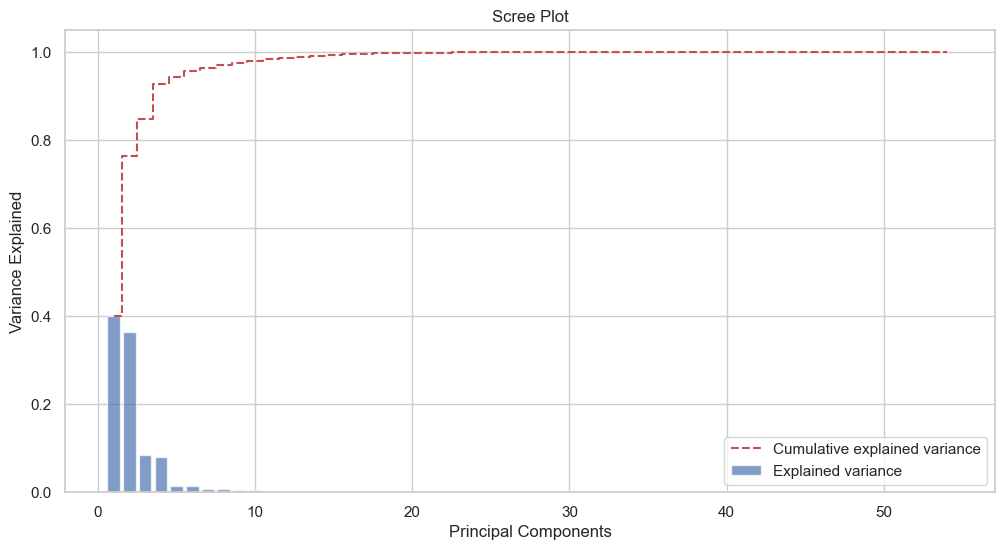

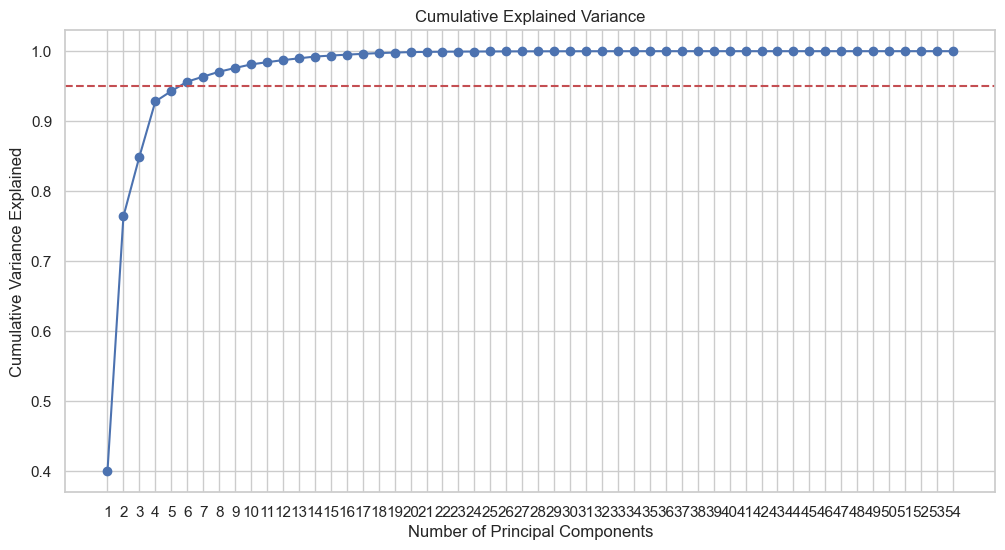

Le nombre optimal de composantes principales est : 6 pour atteindre 95.0% de variance expliquée.


In [245]:
# Création du modèle de PCA
pca_model = PCA()
pca_model.fit(X)

# Fonction pour tracer le Scree plot
def plot_scree(pca):
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='b', label='Explained variance')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', linestyle='--', color='r', label='Cumulative explained variance')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.legend(loc='best')
    plt.show()

# Tracer le Scree plot
plot_scree(pca_model)

# Fonction pour tracer la variance cumulée expliquée
def plot_cumulative_variance(pca, goal_variance):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.axhline(y=goal_variance, color='r', linestyle='--')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.xticks(range(1, len(cumulative_variance) + 1))
    plt.show()

# Tracer la variance cumulée expliquée
goal_variance = 0.95  # Par exemple, 95% de variance expliquée
plot_cumulative_variance(pca_model, goal_variance)

# Fonction pour sélectionner le nombre de composantes principales nécessaires pour atteindre une variance expliquée cible
def find_optimal_components(pca, goal_variance):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= goal_variance) + 1
    return n_components

# Sélection automatique du nombre de composantes principales
optimal_components = find_optimal_components(pca_model, goal_variance)
print(f"Le nombre optimal de composantes principales est : {optimal_components} pour atteindre {goal_variance * 100}% de variance expliquée.")

In [246]:
X_pca

array([[ 3.08979726e+00, -2.17310308e+00, -2.13557104e+00,
         1.83237962e-01, -1.09611864e-03, -1.32007311e+00],
       [-4.81206096e-01, -5.59919520e+00,  1.97684041e+00,
         2.90315867e+00,  4.25909771e-01, -4.13558406e-01],
       [-5.18626513e+00, -1.51346771e+00,  4.10274614e+00,
         2.15218069e+00, -9.14990728e-01, -1.33824879e+00],
       ...,
       [-1.03456615e+00, -2.78012313e+00, -2.50382199e+00,
        -3.14089222e-01, -3.18138846e-01,  8.12570661e-01],
       [ 4.79837121e+00,  2.91802537e+00, -6.57849873e-01,
         1.55740269e+00,  7.92016425e-02,  4.38132922e-01],
       [ 2.32459007e+00, -2.87522790e+00, -2.84955545e+00,
        -7.46682568e-02,  2.81511829e-01,  5.09102589e-01]])

On commence avec les variances expliquées de chaque composantes :

Variance expliquée par chaque composante:
[0.3998037  0.36409868 0.08518941 0.07899243 0.01484699 0.0134956 ]
Variance cumulée expliquée:
[0.3998037  0.76390239 0.8490918  0.92808423 0.94293122 0.95642682]


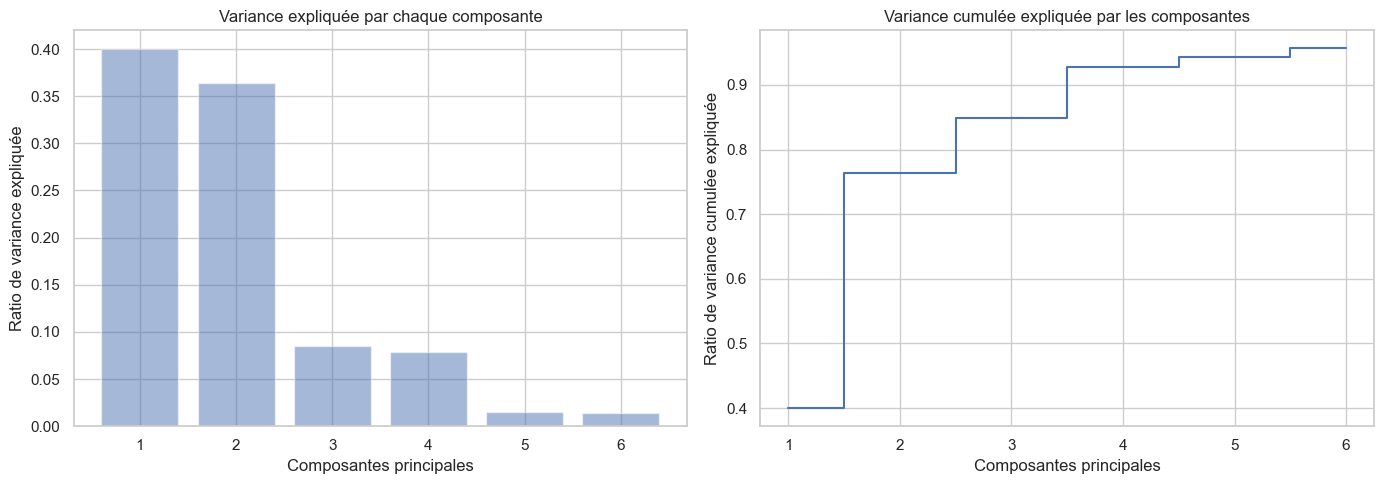

In [247]:
# Nombre de composantes et variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Variance expliquée par chaque composante:")
print(explained_variance)
print("Variance cumulée expliquée:")
print(cumulative_variance)

# Plotting
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha = 0.5, align = 'center', label = 'Variance individuelle expliquée')
plt.xticks(np.arange(1, len(explained_variance)+1, step=1))
plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance expliquée par chaque composante')

plt.subplot(1, 2, 2)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where = 'mid',label = 'Variance cumulée expliquée')
plt.xticks(np.arange(1, len(explained_variance) + 1, step = 1))
plt.ylabel('Ratio de variance cumulée expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance cumulée expliquée par les composantes')

plt.tight_layout()
plt.show()

Affichage des différentes loadings de chaque variables sur chaque composante :

In [248]:
components = pca.components_
num_components = components.shape[0]
feature_names = matches_hist_res.columns.drop(['results', 'home_club_id', 'away_club_id'])

print("Chargements pour les composantes principales:")
for i in range(num_components):
    component = components[i]
    print(f"Composante {i+1}:")
    loadings = pd.Series(component, index=feature_names)
    sorted_loadings = loadings.abs().sort_values(ascending=False)
    print(sorted_loadings.head(15))  # Afficher les 10 variables les plus importantes pour cette composante

NameError: name 'matches_hist_res' is not defined

On veut alors identifier quelle variable à le plus grand impact dans l'espace de PCA, ie sur chaque composante. On définit "l'importance" d'une variable de base telle que :

$$ Importance (var_i) = \sum_{k = 0}^{n_{compo}} loadings_k(var_i)$$

In [ ]:
def calcul_total_importance(pca_components, feature_names):
    total_importance = np.sum(np.abs(pca_components), axis = 0)
    importance_series = pd.Series(total_importance, index=feature_names)
    return importance_series

# Utilisation de la fonction
components = pca.components_
feature_names = matches_hist_res.drop(['results', 'home_club_id', 'away_club_id'], axis = 1).columns # On récupère les noms des variables

# Calcul de l'importance totale
total_importance = calcul_total_importance(components, feature_names)

# Affichage des importances triées par ordre décroissant
sorted_importance = total_importance.sort_values(ascending=False)
print("Importance totale pour chaque variable:")
print(sorted_importance)

# Visualisation des données normalisées par rapport à la plus grande importance des variables.

max_importance = total_importance.max()
normalized_importance_sorted = sorted_importance / max_importance

plt.figure(figsize = ( 12, 8))
normalized_importance_sorted.plot(kind = 'bar')
plt.title("Loadings ayant le plus d'impact sur l'espace de PCA")
plt.ylabel('Pourcentage')
plt.xlabel('Variables')
plt.show()

Ce graphique montre, dans l'ordre décroissant, l'importance de chaque variable déduite par l'algorithme de réduction de dimension. Le pourcentage de match nul semble être la variables les plus importante pour notre problème, on n'y connais rien au foot et le problème est complexe mais ça semble cohérent.

rq : On peut répondre à la question que l'on s'est posée précédemment, les variables semblent en effet marcher en couples. Il faudrait donc adapter son choix de la variance totale expliquée voulue pour avoir un nombre pair de composantes.

Nous avons fini l'algorithme de PCA, il est cohérent et a permit de réduire la dimensionnalité du problème, merci PCA.

### Modèle de prédiction

Notre problème est un problème de classification : étant donné deux clubs avec deux ensembles de statistiques différents, quel résultat vais-je obtenir parmi {-1, 0, 1} ?

In [249]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


On commence par diviser les  données en données d'entraînement et de test, avec ratio test 20/80

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

In [251]:
print(X_train, X_test, y_train, y_test)

[[ 1.04158306 -4.1393369  -1.95673416  0.80912643 -0.86364064  1.62540813]
 [-4.61276048  1.64647236 -0.05183966 -1.05792539 -1.54579282  0.96056968]
 [ 1.10308607  7.2396048   0.48877943 -0.48907412 -0.91793253  0.3529315 ]
 ...
 [-6.47217359 -0.20177286  3.65373168  2.61201516 -0.08924188 -0.47771413]
 [ 0.10855977 -0.3877884   4.01267761  1.08992494  0.8430754  -0.60063538]
 [-0.62977734 -7.73785463  0.41758524  0.79446801 -0.74321552  1.89638184]] [[-2.33718331 -1.99856503  1.13171615 -2.67990345  0.65751044  0.87370055]
 [ 9.64676791  9.70734389  4.66211643  0.89838823  0.41347747  1.10335545]
 [-3.34129691  4.40160952 -1.40836961 -0.49811619  0.79341638 -0.45043812]
 ...
 [-4.3485011   3.94776977 -1.43242383 -1.44140169  0.50845994  0.74807176]
 [ 2.83724523 -0.95702571  0.08079303 -2.73099821  1.05003901  0.05848582]
 [ 4.21504222  1.98674801  0.65438886 -1.67675776 -0.39787033 -0.95460081]] 3569    1
1330   -1
1749    0
88      0
1488    1
       ..
1130    1
1294    0
860     

### Support Vector Classifier (SVC)

Pour entrainer le modèle de SVC optimale, on vas tester plusieurs kernels et plusieurs paramètres. Heureusement, l'import suivant nous facilite la vie :

In [252]:
from sklearn.model_selection import GridSearchCV

#On utilisera l'option n_jobs = -1 pour matraquer tous les coeurs du cpu.

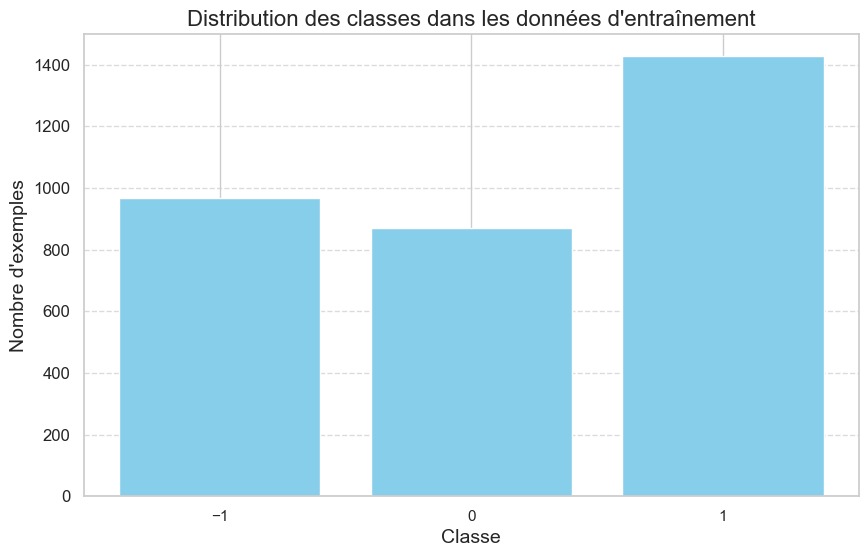

In [253]:
# Vérification de l'équilibre des classes dans les données d'entraînement, trés important pour le GridSearchCV
class_counts = y_train.value_counts()
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Distribution des classes dans les données d\'entraînement', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Nombre d\'exemples', fontsize=14)
plt.xticks(class_counts.index, rotation=0)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


On créer la grille de paramètres à tester :

In [254]:
# Définir la grille de paramètres pour GridSearchCV avec class_weight='balanced'
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10], 'class_weight': ['balanced']},
    {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['scale'], 'class_weight': ['balanced']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale'], 'class_weight': ['balanced']}
]


On effectue la recherche :

In [255]:
# Création de l'instance de GridSearchCV avec le modèle SVM
svm_model = SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=10, n_jobs=-1)

# Entraînement de GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                          'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                          'gamma': ['scale'], 'kernel': ['rbf', 'sigmoid']},
                         {'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                          'degree': [2, 3], 'gamma': ['scale'],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=10)

On affiche les résultats :

In [256]:
# Affichage des meilleurs paramètres et du score de validation croisée
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Évaluation des performances sur le jeu de test
test_accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Set: {test_accuracy:.2f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, zero_division=0))

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best cross-validation score: 0.46
Accuracy on Test Set: 0.47
Classification Report on Test Set:
              precision    recall  f1-score   support

          -1       0.46      0.45      0.45       237
           0       0.29      0.39      0.33       204
           1       0.64      0.53      0.58       375

    accuracy                           0.47       816
   macro avg       0.46      0.46      0.45       816
weighted avg       0.50      0.47      0.48       816



### Rapport de la modélisation par SVC :

On va procéder à l'analyse du modèle qu'on a choisit d'utiliser, commençons par les imports :

In [257]:
from sklearn.metrics import confusion_matrix

- Matrice de Confusion

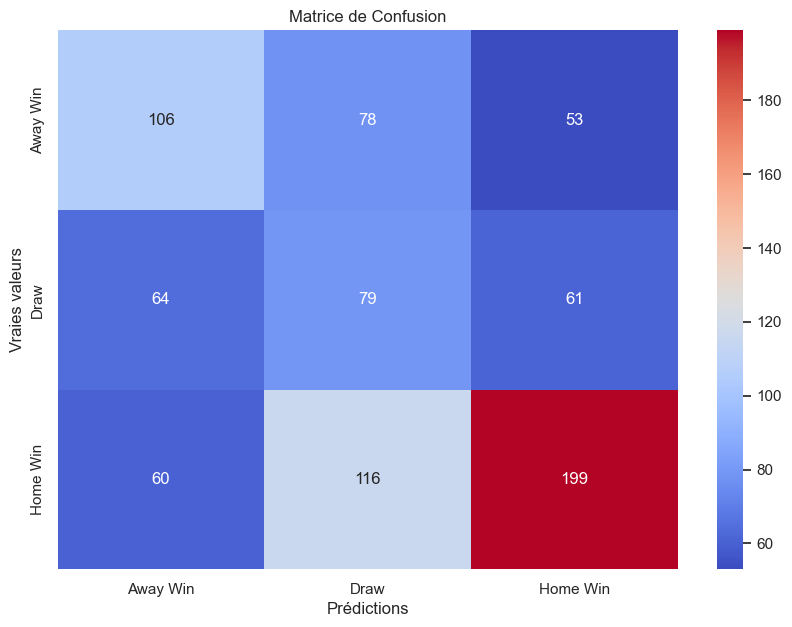

In [258]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

- Rapport de classification

In [259]:
report = classification_report(y_test, predictions, target_names=['Away Win', 'Draw', 'Home Win'])
print(report)

              precision    recall  f1-score   support

    Away Win       0.46      0.45      0.45       237
        Draw       0.29      0.39      0.33       204
    Home Win       0.64      0.53      0.58       375

    accuracy                           0.47       816
   macro avg       0.46      0.46      0.45       816
weighted avg       0.50      0.47      0.48       816



Le modèle atteint une précision de 47 %, ce qui est meilleur qu'un modèle aléatoire avec une précision de 33 %. Succés!!!

$\space$

## Prédiction

C'est le moment de prédire le futur!!!

On rapelle la structure du dataframe

In [260]:
match_pred.columns

Index(['game_id', 'home_club_id', 'away_club_id'], dtype='object')

In [261]:
match_pred

,game_id,home_club_id,away_club_id
0,4094596,583,826
1,4094622,826,347
2,4094630,969,273
3,4094647,347,417
4,4094696,244,273
...,...,...,...
265,4094819,738,969
266,4094840,415,244
267,4094776,583,273
268,4094786,415,417


Assurons-nous que nous disposons de toutes les données nécessaires pour prédire les matchs. Puisque chaque club joue au moins un match à domicile, nous pouvons extraire les IDs de tous les clubs de la manière suivante :

In [262]:
stat_club_ids = set(club_data['club_id'].tolist())
pred_club_ids = set(match_pred['home_club_id'].tolist())

print(stat_club_ids, pred_club_ids)

{1158, 1159, 1160, 1416, 1162, 1420, 1421, 1423, 273, 1041, 2969, 667, 415, 417, 162, 290, 40, 1082, 826, 3524, 583, 1095, 969, 3911, 595, 855, 347, 14171, 995, 3558, 618, 750, 244, 1147} {417, 162, 738, 3524, 1082, 1158, 583, 3911, 969, 995, 1421, 273, 1041, 244, 826, 347, 667, 415}


In [263]:
intersection = set(stat_club_ids) & set(pred_club_ids)

On a un problème avec les clubs présent dans les matchs à prédire, il n'est pas dans club_stat('club_id') : Un club a accédé en L1 en 2023 sans y avoir été durant la période 2013 - 2022. Cherchons le(s)quel(s) :

In [264]:
print(pred_club_ids - stat_club_ids)

{738}


Le coupable est le club 738 ou "Le Havre Athletic Club". Nous allons supprimer le club. 

In [265]:
club_data_norm = club_data_norm[club_data_norm['club_id'] != 738]

Obtention des statistiques synthétiques.

In [266]:
club_data_norm

,club_id,name,name_abrv,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean,...,average_goals_conceded,average_goals_scored_home,average_goals_scored_away,percentage_wins,percentage_draws,percentage_losses,goals_per_match,efficiency_ratio,goal_diff,points_per_match
0,40,FC Girondins Bordeaux,FCGB,0.610493,0.949115,1.440329,0.591526,0.004211,1.153315,-0.368855,...,-0.309007,0.004211,0.241533,0.069868,0.325226,-0.594423,0.113667,0.019764,-0.212574,0.234407
1,162,Association sportive de Monaco Football Club,AMFC,1.373610,-0.144780,0.792094,1.451548,1.710697,0.887731,-0.820862,...,-1.151918,1.710697,1.897001,1.796992,2.018316,-1.826437,1.843868,1.345588,1.541165,1.823926
2,244,Olympique de Marseille,OM,1.475359,0.402167,1.145677,1.372647,1.033826,1.231428,-0.773976,...,-1.304191,1.033826,1.295636,1.446111,1.633864,-1.620576,1.184441,1.052631,1.242232,1.514881
3,273,Stade Rennais Football Club,SRFC,1.144675,1.313747,1.027816,1.064933,0.473071,1.200183,-0.819153,...,-1.000678,0.473071,0.648226,0.641225,0.346109,-0.697616,0.568026,0.534314,0.551365,0.665169
4,290,AJ Auxerre,AJA,-1.220987,-1.724851,-1.447262,-1.254760,-1.234169,-1.705619,1.137730,...,1.196097,-1.234169,-0.535405,-1.036097,0.017653,0.905420,-0.938671,-0.801886,-0.186003,-1.005506
5,347,Football Club de Metz,FCM,-0.610493,0.827571,-0.032932,-0.394738,-0.595412,0.622147,1.829719,...,1.187239,-0.595412,-0.998591,-0.868959,-0.479981,0.814505,-0.800674,-0.745229,-1.003086,-0.860527
6,415,Toulouse Football Club,TFC,0.025437,1.252975,1.381399,0.331153,-0.119840,1.262673,0.435128,...,0.306150,-0.119840,-0.585792,-0.525348,0.177829,0.368148,-0.346323,-0.374106,-0.797154,-0.481431
7,417,Olympique Gymnaste Club Nice Côte d'Azur,OGCNCA,1.322735,1.252975,0.733164,0.978142,0.293797,1.215805,-0.820255,...,-1.113090,0.293797,0.207107,0.880516,0.296580,-0.819058,0.263822,0.413506,0.365362,0.870010
8,583,Paris Saint-Germain Football Club,PSGFC,2.696345,-1.238676,-0.091862,2.966450,3.938252,-0.002757,-2.558472,...,-2.801679,3.938252,3.562832,3.463056,2.792867,-2.880710,3.869392,4.586634,4.344490,3.315336
9,595,SC Bastia,SCB,-0.254372,-0.630956,-0.268653,-0.465749,-0.369652,-0.737019,-1.287568,...,-0.034996,-0.369652,-0.864670,-0.148548,-0.726846,0.227389,-0.612051,-0.413603,-0.465007,-0.174641


### Fichier de prédiction

On écrit une fonction qui extrait les stats des clubs qui s'opposent :

In [267]:
def extract_features(home_club_id, away_club_id):
    # Extraction des statistiques des clubs pour le club à domicile et le club à l'extérieur
    home_stats = club_data_norm[club_data_norm['club_id'] == home_club_id]
    away_stats = club_data_norm[club_data_norm['club_id'] == away_club_id]
    
    # Suppression des colonnes inutiles
    columns_to_drop = ['club_id', 'name', 'name_abrv']
    home_stats = home_stats.drop(columns=columns_to_drop)
    away_stats = away_stats.drop(columns=columns_to_drop)
    
    # Ajout du préfixe '_away' aux colonnes du club à l'extérieur
    away_stats.columns = [f'{col}_away' for col in away_stats.columns]

    # Réinitialisation des index pour la concaténation
    home_stats.reset_index(drop=True, inplace=True)
    away_stats.reset_index(drop=True, inplace=True)

    # Concaténation des caractéristiques des deux clubs
    features = pd.concat([home_stats, away_stats], axis=1)
    
    return features

In [268]:
# Test de la prédiction. On récupère les données des deux clubs, on les agrège puis on les normalises 
features = extract_features(969, 40)
features

,home_win_sum,home_loss_sum,home_draw_sum,home_scored_g_sum,home_scored_g_mean,home_tried_g_sum,home_tried_g_mean,ext_win_sum,ext_loss_sum,ext_draw_sum,...,average_goals_conceded_away,average_goals_scored_home_away,average_goals_scored_away_away,percentage_wins_away,percentage_draws_away,percentage_losses_away,goals_per_match_away,efficiency_ratio_away,goal_diff_away,points_per_match_away
0,0.890303,1.739151,1.204607,1.017592,0.3868,1.575125,-0.277027,0.56163,1.576027,1.517037,...,-0.309007,0.004211,0.241533,0.069868,0.325226,-0.594423,0.113667,0.019764,-0.212574,0.234407


In [284]:
features_pca = pca.transform(features)
predicted = best_model.predict(features_pca)
predicted

array([1], dtype=int64)

Wow, il serait l'heure de commencer à parier et payer l'école pour l'année prochaine!!! (Je le recommande pas)

In [287]:
match_pred = match_pred[(match_pred['home_club_id'] != 738) & (match_pred['away_club_id'] != 738)]


In [291]:
Predictions = []

for index, row in match_pred.iterrows():
    features = extract_features(row['home_club_id'], row['away_club_id'])
    features_pca = pca.transform(features_normed)  # Apply PCA
    
    Predictions.append((row['game_id'], prediction[0]))  # Append game_id and result

# Convert the results into a DataFrame
predictions = pd.DataFrame(Predictions, columns=['game_id', 'results'])
predictions.to_csv("prediction.csv", index = False)

FINITO!